<a href="https://colab.research.google.com/github/LeraDoroshenko/ksvd/blob/main/%D0%9B%D0%A05_%D0%94%D0%BE%D1%80%D0%BE%D1%88%D0%B5%D0%BD%D0%BA%D0%BE%D0%92_4_6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
gpiosenka_sports_classification_path = kagglehub.dataset_download('gpiosenka/sports-classification')

print('Data source import complete.')


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.metrics import confusion_matrix, classification_report, f1_score
from tqdm import tqdm

In [ ]:
train_dir = '/kaggle/input/sports-classification/train'
val_dir = '/kaggle/input/sports-classification/valid'
test_dir = '/kaggle/input/sports-classification/test'

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [ ]:
train_dataset = datasets.ImageFolder(train_dir, transform=transform)
val_dataset = datasets.ImageFolder(val_dir, transform=transform)
test_dataset = datasets.ImageFolder(test_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, num_workers=2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, num_workers=2, pin_memory=True)

class_names = train_dataset.classes

In [ ]:
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

In [ ]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
best_val_loss = float('inf')
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

    val_loss /= len(val_loader)
    val_acc = correct / total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_resnet50.pth')

model.load_state_dict(torch.load('best_resnet50.pth'))

Epoch 1/10: 100%|██████████| 422/422 [00:24<00:00, 17.55it/s]


Train Loss: 1.7184, Train Acc: 0.7120
Val Loss: 0.5889, Val Acc: 0.9020


Epoch 2/10: 100%|██████████| 422/422 [00:22<00:00, 18.60it/s]


Train Loss: 0.5031, Train Acc: 0.9206
Val Loss: 0.3610, Val Acc: 0.9280


Epoch 3/10: 100%|██████████| 422/422 [00:22<00:00, 18.55it/s]


Train Loss: 0.3011, Train Acc: 0.9540
Val Loss: 0.2886, Val Acc: 0.9500


Epoch 4/10: 100%|██████████| 422/422 [00:22<00:00, 18.48it/s]


Train Loss: 0.2033, Train Acc: 0.9744
Val Loss: 0.2435, Val Acc: 0.9340


Epoch 5/10: 100%|██████████| 422/422 [00:22<00:00, 18.45it/s]


Train Loss: 0.1448, Train Acc: 0.9849
Val Loss: 0.2181, Val Acc: 0.9500


Epoch 6/10: 100%|██████████| 422/422 [00:22<00:00, 18.56it/s]


Train Loss: 0.1077, Train Acc: 0.9922
Val Loss: 0.1981, Val Acc: 0.9540


Epoch 7/10: 100%|██████████| 422/422 [00:22<00:00, 18.56it/s]


Train Loss: 0.0822, Train Acc: 0.9947
Val Loss: 0.1920, Val Acc: 0.9480


Epoch 8/10: 100%|██████████| 422/422 [00:22<00:00, 18.47it/s]


Train Loss: 0.0646, Train Acc: 0.9968
Val Loss: 0.1853, Val Acc: 0.9480


Epoch 9/10: 100%|██████████| 422/422 [00:22<00:00, 18.54it/s]


Train Loss: 0.0525, Train Acc: 0.9973
Val Loss: 0.1697, Val Acc: 0.9500


Epoch 10/10: 100%|██████████| 422/422 [00:22<00:00, 18.48it/s]


Train Loss: 0.0436, Train Acc: 0.9982
Val Loss: 0.1588, Val Acc: 0.9480


/tmp/ipykernel_31/1010349100.py:60: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('best_resnet50.pth'))


<All keys matched successfully>

In [ ]:
model.eval()
correct = 0
total = 0
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

test_acc = correct / total
print(f'\nTest Accuracy: {test_acc:.4f}')
print('\nClassification Report:')
print(classification_report(all_labels, all_preds, target_names=class_names))


Test Accuracy: 0.9760

Classification Report:
                       precision    recall  f1-score   support

           air hockey       1.00      1.00      1.00         5
      ampute football       1.00      1.00      1.00         5
              archery       1.00      1.00      1.00         5
        arm wrestling       1.00      1.00      1.00         5
         axe throwing       1.00      1.00      1.00         5
         balance beam       1.00      1.00      1.00         5
        barell racing       1.00      1.00      1.00         5
             baseball       1.00      0.80      0.89         5
           basketball       1.00      1.00      1.00         5
       baton twirling       1.00      1.00      1.00         5
            bike polo       1.00      1.00      1.00         5
            billiards       1.00      1.00      1.00         5
                  bmx       1.00      1.00      1.00         5
              bobsled       1.00      0.80      0.89         5
       

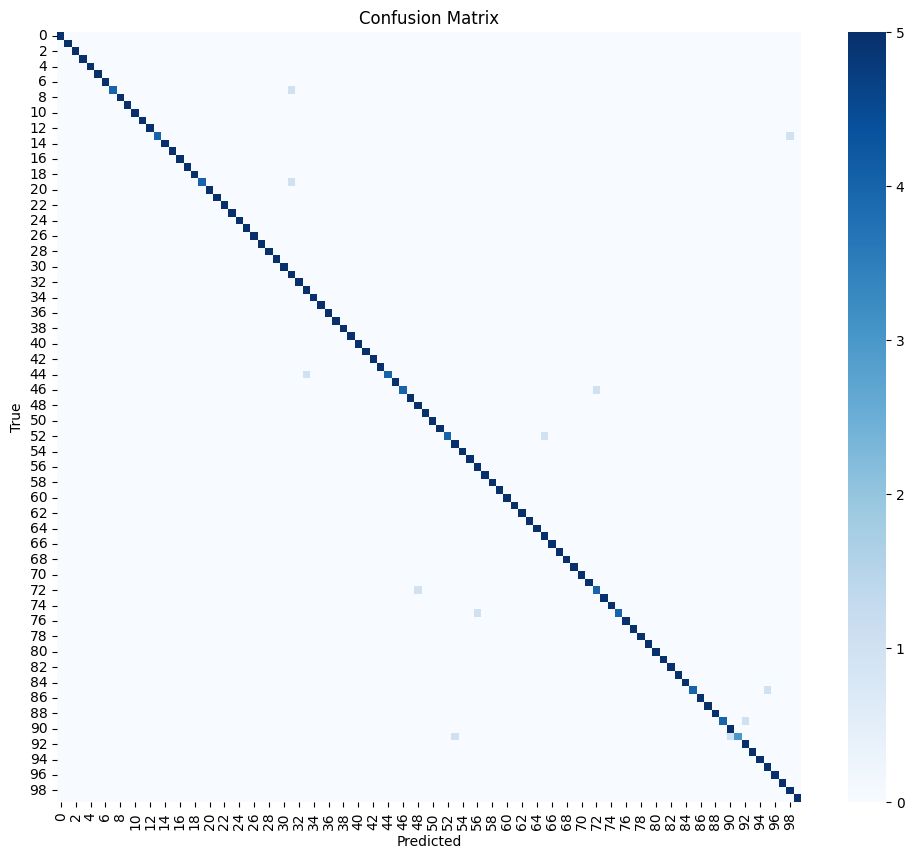

In [ ]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=False, cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

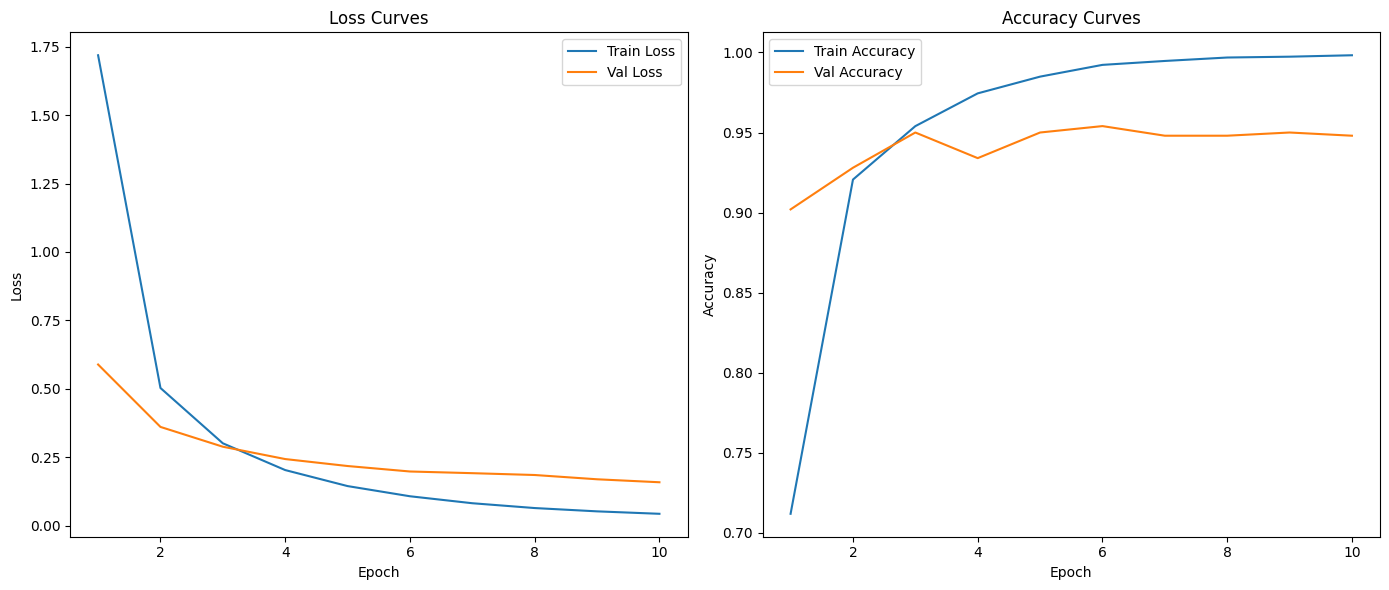

In [ ]:
epochs = range(1, num_epochs + 1)
plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_losses, label='Train Loss')
plt.plot(epochs, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curves')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_accuracies, label='Train Accuracy')
plt.plot(epochs, val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Curves')
plt.legend()

plt.tight_layout()
plt.show()

У ході виконання лабораторної роботи було реалізовано задачу класифікації зображень за допомогою глибокої нейронної мережі ResNet50. Було проведено попередню обробку даних, включаючи нормалізацію та зміну розміру зображень, що дозволило адаптувати вхідні дані до вимог моделі. Модель була модифікована шляхом заміни останнього повнозв'язного шару відповідно до кількості класів у датасеті.

Для оптимізації процесу навчання було використано попередньо натреновані моделі ResNet50, заморожено параметри ранніх шарів моделі для зосередження навчання на останніх шарах та застосовано оптимізатор Adam з відповідними параметрами.

Результати навчання були оцінені за допомогою метрик точності та F1-міри, а також побудовано матрицю плутанини для візуалізації результатів класифікації.